## Background

As I've been preparing to build [highly performant tiny LMs](https://vishalbakshi.github.io/blog/index.html#category=TinyScaleLab), I realized I needed a refresher on how Cross-Entropy loss works. In this notebook I'm revisiting [Chapter 5 of fastbook](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb) to walk through the code and concepts introduced to build intuition around this loss function.

I was motivated to work on this refresher because I wanted to better visualize with a concrete example how small batch training can lead to noisy gradients.

## Multi-Class Classification

We are going to focus on a single-label, multiple class classification problem using the PETS dataset.

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 138MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.499396,0.378620,0.125169,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.536576,0.329664,0.104871,01:08
1,0.326150,0.241802,0.078484,01:08


Inspecting one batch, we see that the inputs are a batch of 64 3-channel 224x224 pixel images, and the targets are integers (between 0 and 36, the number of pet classes in the dataset)

In [ ]:
x,y = dls.one_batch()

In [ ]:
x.shape

torch.Size([64, 3, 224, 224])

In [ ]:
y

TensorCategory([23, 13, 25,  3, 16, 31, 34,  8,  9, 20, 19, 10,  6, 19, 33, 35,
                34, 19, 18, 29, 26, 34, 24, 30, 31,  2,  3, 20, 28, 29,  0, 11,
                22, 31,  3, 36, 15, 16,  0, 18, 32, 17,  3, 18, 16,  6, 16,  2,
                32,  0,  9, 26, 26, 35, 18,  4, 36,  5, 17,  0, 11, 27, 21, 35],
               device='cuda:0')

In [ ]:
y.shape

torch.Size([64])

Passing this batch to the trained model we get back 37 predictions for each item in the batch.

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([2.0166e-08, 1.0262e-06, 6.8535e-06, 2.8387e-06, 7.7887e-08, 1.4034e-07,
        4.1744e-07, 9.1272e-06, 1.0166e-05, 1.3550e-07, 5.2067e-08, 3.7820e-06,
        4.2456e-06, 1.2272e-08, 1.2251e-07, 1.4040e-07, 7.0171e-06, 4.2623e-04,
        1.3611e-07, 7.3574e-08, 1.6146e-08, 5.0945e-06, 8.1139e-06, 9.9821e-01,
        4.9108e-05, 3.4051e-06, 7.8016e-09, 2.8509e-07, 1.0994e-03, 1.3271e-06,
        1.4462e-04, 4.8486e-07, 1.3296e-07, 7.4560e-07, 6.1535e-08, 7.6703e-07,
        9.5345e-07])

In [ ]:
preds.shape

torch.Size([64, 37])

In [ ]:
x.shape, y.shape, preds[0].shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]), torch.Size([37]))

In [ ]:
len(preds[0]),preds[0].sum()

(37, tensor(1.))

The predictions for each batch item sum to `1.0`.

## Building Up Cross-Entropy Loss

We'll work through a simpler example: binary classification with two classes (and thus two model outputs/activations).

In [ ]:
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

We want each row (batch item) to sum to 1.0. In other words, we want to turn these activations into probabilities. Passing each item through sigmoid does not help. While it does constrain the value to 0 and 1 it does so independently across the two classes so they don't add up to 1.0.

In [ ]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    min = torch.tensor(min)
    max = torch.tensor(max)
    x = torch.linspace(min,max, 100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

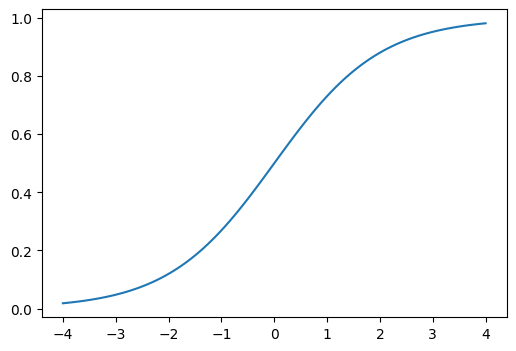

In [ ]:
plot_function(f=torch.sigmoid, min=-4,max=4)

In [ ]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [ ]:
acts[0][0].sigmoid()

tensor(0.6623)

However, taking the difference _between the class activations_ and then passing that through the sigmoid does give us our desired result: probabilities that sum up to 1.0 across classes for each batch item.

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [ ]:
(acts[:,1]-acts[:,0]).sigmoid()

tensor([0.3975, 0.4979, 0.8668, 0.0034, 0.4041, 0.6339])

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid() + (acts[:,1]-acts[:,0]).sigmoid()

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

Why does this work? We can see why mathematically.

### Deriving Softmax from Sigmoid

We start with taking the sigmoid of the difference between the first and second class activations.

$$\text{sigmoid}(x_1-x_2)\text{ = }\frac{1}{1+e^{-{(x_1-x_2)}}}$$

Let's rewrite the denominator, expanding the exponent term:

$$1+e^{-{(x_1-x_2)}} = 1 + \frac{1}{e^{(x_1-x_2)}} = \frac{1}{1}+\frac{1}{e^{(x_1-x_2)}} = \frac{e^{(x_1-x_2)}+1}{e^{(x_1-x_2)}}$$

Plugging that back into the original sigmoid fraction and simplifying:

$$\frac{1}{1+e^{-{(x_1-x_2)}}} = \frac{1}{\frac{e^{(x_1-x_2)}+1}{e^{(x_1-x_2)}}} = \frac{e^{(x_1-x_2)}}{e^{(x_1-x_2)}+1}$$

Multiplying by a term equivalent to 1 (thanks Gemini):


$$\frac{e^{(x_1-x_2)}}{e^{(x_1-x_2)}+1} \times \frac{e^{x_2}}{e^{x_2}} = \frac{e^{(x_1-x_2)}\times e^{x_2}}{(e^{(x_1-x_2)}+1)\times e^{x_2}} = \frac{e^{(x_1-x_2+x_2)}}{e^{(x_1-x_2+x_2)}+e^{x_2}}=\frac{e^{x_1}}{e^{x_1}+e^{x_2}}$$

We are left with the softmax calculation for the first class probability. The chapter goes on to say:

> The second column (the probability of it being a 7) will then just be that value subtracted from 1.

The sigmoid of the difference between the second and first class probabilities is 1 minus the sigmoid of the difference between the first and second class probabilities.

$$\text{sigmoid}(x_2-x_1)\text{ = }1 - \frac{e^{x_1}}{e^{x_1}+e^{x_2}} = \frac{e^{x_1}+e^{x_2}}{e^{x_1}+e^{x_2}} - \frac{e^{x_1}}{e^{x_1}+e^{x_2}} = \frac{e^{x_1}+e^{x_2}-e^{x_1}}{e^{x_1}+e^{x_2}} = \frac{e^{x_2}}{e^{x_1}+e^{x_2}}$$

In [ ]:
1 - (acts[:,0]-acts[:,1]).sigmoid()

tensor([0.3975, 0.4979, 0.8668, 0.0034, 0.4041, 0.6339])

We can also derive the same result with a different approach mathematically, I find this one to be simpler:

$$\text{sigmoid}(x_1-x_2)\text{ = }\frac{1}{1+e^{-{(x_1-x_2)}}}$$

Expanding the exponent term in the denominator:

$$e^{-(x_1-x_2)} = \frac{1}{e^{(x_1-x_2)}} = \frac{1}{\frac{e^{x_1}}{e^{x_2}}} = \frac{e^{x_2}}{e^{x_1}}$$

Plugging that back into the denominator and massaging it:

$$1+\frac{e^{x_2}}{e^{x_1}} = \frac{e^{x_1}}{e^{x_1}} + \frac{e^{x_2}}{e^{x_1}} = \frac{e^{x_1} + e^{x_2}}{e^{x_1}}$$

Plugging that back in to the original sigmoid equation:

$$\text{sigmoid}(x_1-x_2)\text{ = }\frac{1}{1+e^{-{(x_1-x_2)}}} = \frac{1}{\frac{e^{x_1} + e^{x_2}}{e^{x_1}}} = \frac{e^{x_1}}{e^{x_2}+e^{x_1}}$$

Mathematically, with some help from Gemini, that makes sense. But what is the conceptual intuition behind it? Why does taking the sigmoid of _the difference between activations_ equate to softmax?

With loads of help with Gemini, I've come to the following conclusions/intuitions:

- sigmoid is designed for a simple binary outcome: A and not-A, so we can't use it for more than 2 classes.
- the difference in logits is a difference in "learned evidence" between the two classes. The value `x_1 - x_2` represents the log-odds of class 1 relative to class 2 (i.e., it's equal to `log(P(class 1)/P(class 2))`). A difference of `0` (logits `x_1` and `x_2` are equal) passed through sigmoid yields a probability of `0.5`, meaning both classes are equally probable.
- sigmoid is the inverse function of the log-odds (or logit) function. sigmoid(0) = 0.5, and log(0.5/(1-0.5)) = 0.
- we call binary classification activations "logits" because we eventually turn them into probabilities using sigmoid.
- the softmax function is the general template for all classification problems. For the special case of exactly two classes, this general formula mathematically simplifies to be identical to the sigmoid of the difference between the logits.
- For 3+ classes, the model's final activations are still called logits. However, they no longer have a simple interpretation as the log-odds of a single event. We think of them as some kind of learned "raw" or "uncalibrated" scores that softmax converts into a valid probability distribution.

Let's return back to the process of building up Cross Entropy loss.

### Selecting the Probabilities Used and Calculating their Logarithm

So we have now converted logits into probabilities using softmax.

 >Our activations, after softmax, are between 0 and 1, and sum to 1 for each row in the batch of predictions.

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Okay great, now how do we use these values? We want to penalize the language model's predictions when they wrong (the target label is not predicted with the highest probability) and especially when they are wrong _and_ confident (the target label is predicted with a very low probability). On the other hand, we want to encourage the model to pick the right class confidently. We achieve this two-pronged behavior by taking the logarithm of the target probability.

Suppose the target classes (`0` or `1`) are as follows for the 6-item batch:

In [ ]:
targ = tensor([0,1,0,1,1,0])
targ

tensor([0, 1, 0, 1, 1, 0])

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

We index into our probalities using `idx` (the batch item index) and `targ` (the probability column index).

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

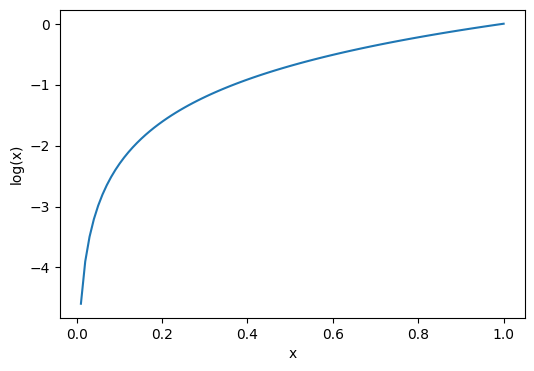

In [ ]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

The log function is very negative for values close to 0 and less negative for values close to 1. We want our loss function to be very positively large for confidently wrong predictions (i.e. when the target class is predicted with a very low probability) so we want to flip the logarithm's behavior by multiplying it by -1.

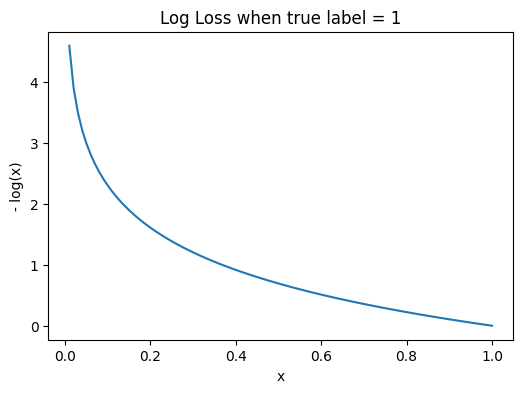

In [ ]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

In [ ]:
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [ ]:
-torch.log(sm_acts)[idx, targ]

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

We now have large loss values (2.016, 5.6958) for batch items when the model predicted the target class with a very low probability (0.1332, 0.0034), and we have a relatively smaller loss value (0.5067) when the model predicted the target class with a higher probability than the incorrect class (0.6025).  

The PyTorch `F.nll_loss` function does the indexing and multiplying by negative 1 operations for us, though it expects you to pass it activations after taking the logarithm of them.

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
F.nll_loss(torch.log(sm_acts), targ, reduction='none')

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

> As long as the activation columns sum to 1 (as they will, if we use softmax), then we'll have a loss function that shows how well we're predicting each digit. Therefore, making the activation for the correct label as high as possible must mean we're also decreasing the activations of the remaining columns.

We can also directly use `CrossEntropyLoss`

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

In [ ]:
nn.CrossEntropyLoss(reduction='mean')(acts, targ)

tensor(1.8045)

> Taking the mean of the negative log of our probabilities (taking the mean of the loss column of our table) gives us the negative log likelihood loss, which is another name for cross-entropy loss.

## The Gradient of Cross Entropy Loss

Let's recreate with code the following explanation of the cross-entropy loss gradient.

> An interesting feature about cross-entropy loss appears when we consider its gradient. The gradient of cross_entropy(a,b) is just softmax(a)-b. Since softmax(a) is just the final activation of the model, that means that the gradient is proportional to the difference between the prediction and the target. This is the same as mean squared error in regression (assuming there's no final activation function such as that added by y_range), since the gradient of (a-b)\*\*2 is 2*(a-b). Because the gradient is linear, that means we won't see sudden jumps or exponential increases in gradients, which should lead to smoother training of models.

First we'll calculate the gradients using `los.backward()`.

In [ ]:
acts = acts.requires_grad_()
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]], requires_grad=True)

In [ ]:
loss = nn.CrossEntropyLoss(reduction='sum')(acts, targ)
loss

tensor(10.8268, grad_fn=<NllLossBackward0>)

In [ ]:
loss.backward()

In [ ]:
acts.grad

tensor([[-0.3975,  0.3975],
        [ 0.5021, -0.5021],
        [-0.8668,  0.8668],
        [ 0.9966, -0.9966],
        [ 0.5959, -0.5959],
        [-0.6339,  0.6339]])

Then, we'll manually calculate them using `softmax(acts) - targ`:

In [ ]:
b = F.one_hot(targ, num_classes=acts.shape[1]).float()
b

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])

In [ ]:
acts.softmax(dim=1) - b

tensor([[-0.3975,  0.3975],
        [ 0.5021, -0.5021],
        [-0.8668,  0.8668],
        [ 0.9966, -0.9966],
        [ 0.5959, -0.5959],
        [-0.6339,  0.6339]], grad_fn=<SubBackward0>)

We see that they are equal! If we want to recreate the gradient when `reduction='mean'` we can divide `softmax(a) - b` by the batch size.

In [ ]:
torch.random.manual_seed(42)
acts = torch.randn((6,2))*2
acts = acts.requires_grad_()

In [ ]:
loss = nn.CrossEntropyLoss(reduction='mean')(acts, targ)
loss

tensor(1.8045, grad_fn=<NllLossBackward0>)

In [ ]:
loss.backward()

In [ ]:
acts.grad

tensor([[-0.0663,  0.0663],
        [ 0.0837, -0.0837],
        [-0.1445,  0.1445],
        [ 0.1661, -0.1661],
        [ 0.0993, -0.0993],
        [-0.1056,  0.1056]])

In [ ]:
(acts.softmax(dim=1) - b) / acts.shape[0]

tensor([[-0.0663,  0.0663],
        [ 0.0837, -0.0837],
        [-0.1445,  0.1445],
        [ 0.1661, -0.1661],
        [ 0.0993, -0.0993],
        [-0.1056,  0.1056]], grad_fn=<DivBackward0>)

## Closing Thoughts

Next-token language generation is fundamentally a classification problem. The "classes" are the tokens in the vocabulary. The model predicts the most probable next token, learning to favor target tokens during training using cross-entropy. This refresher on cross-entropy loss helped me solidify my understanding of how this behavior is reinforced.

I'm growing my YouTube channel so if you like this type of content [please subscribe](https://www.youtube.com/@vishal_learner)!